# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('There are ', azdias.shape[0], 'rows and ', azdias.shape[1], 'columns in the general population dataset')


There are  891221 rows and  85 columns in the general population dataset


In [4]:
azdias.head(n=3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


In [5]:
print('There are', feat_info.shape[0], 'rows and', feat_info.shape[1], 'columns in the feature summary dataset')


There are 85 rows and 4 columns in the feature summary dataset


In [6]:
feat_info.head(n=3)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.

# Number of missing values by variable
missing_value_counts = azdias.isna().sum()
missing_value_counts[missing_value_counts > 0]

CJT_GESAMTTYP            4854
GFK_URLAUBERTYP          4854
LP_LEBENSPHASE_FEIN      4854
LP_LEBENSPHASE_GROB      4854
LP_FAMILIE_FEIN          4854
LP_FAMILIE_GROB          4854
LP_STATUS_FEIN           4854
LP_STATUS_GROB           4854
RETOURTYP_BK_S           4854
SOHO_KZ                 73499
TITEL_KZ                73499
ALTER_HH                73499
ANZ_PERSONEN            73499
ANZ_TITEL               73499
HH_EINKOMMEN_SCORE      18348
KK_KUNDENTYP           584612
W_KEIT_KIND_HH         107602
WOHNDAUER_2008          73499
ANZ_HAUSHALTE_AKTIV     93148
ANZ_HH_TITEL            97008
GEBAEUDETYP             93148
KONSUMNAEHE             73969
MIN_GEBAEUDEJAHR        93148
OST_WEST_KZ             93148
WOHNLAGE                93148
CAMEO_DEUG_2015         98979
CAMEO_DEU_2015          98979
CAMEO_INTL_2015         98979
KBA05_ANTG1            133324
KBA05_ANTG2            133324
KBA05_ANTG3            133324
KBA05_ANTG4            133324
KBA05_BAUMAX           133324
KBA05_GBZ 

In [8]:
# Total missing values 
azdias.isnull().sum().sum()

4896838

In [9]:
# Missing/Unknown unique values
feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [10]:
# Convert missing or unknown column into list
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].str.strip('[]').str.split(',')

In [11]:
# replace missing or unknown values with np.nan based on attribute
for i in range(len(feat_info)):
    missing_value_encoding = feat_info.iloc[i]['missing_or_unknown'] # for each row in column
    missing_value_encoding = list(int(value) if value not in ('XX', 'X', '') else value
                                  for value in missing_value_encoding) 
    # Place values for missing values into a list & convert integers to integer type
    missing_value_dictionary = {feat_info.iloc[i]['attribute']: missing_value_encoding}
    azdias = azdias.replace(missing_value_dictionary, np.nan) 
    #replace with np.nan based on the code for each attribute from the dictionary


In [12]:
# New total missing values
azdias.isnull().sum().sum()


8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_value_counts = azdias.isna().sum().sort_values(ascending=False)
missing_value_counts[missing_value_counts > 0]

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
CAMEO_DE

In [14]:
# Investigate patterns in the amount of missing data in each column.

# Proportion of values in each column that are null
percent_null = azdias.isnull().sum()/len(azdias) * 100

percent_null[percent_null >0]

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
CJT_GESAMTTYP             0.544646
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SHOPPER_TYP              12.476816
SOHO_KZ                   8.247000
TITEL_KZ                 99.757636
VERS_TYP                 12.476816
ALTER_HH                 34.813699
ANZ_PERSONEN              8.247000
ANZ_TITEL                 8.247000
HH_EINKOMMEN_SCORE        2.058749
KK_KUNDENTYP             65.596749
W_KEIT_KIND_HH           16.605084
WOHNDAUER_2008            8.247000
ANZ_HAUSHALTE_AKTIV      11.176913
ANZ_HH_TITEL             10.884842
GEBAEUDETYP         

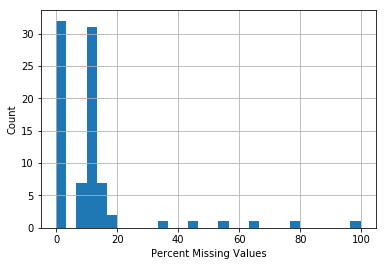

In [15]:
# Histogram of Missing Value Percent for each column

plt.hist(percent_null, bins = 30)
plt.ylabel('Count')
plt.xlabel('Percent Missing Values')
plt.grid(True)

In [16]:
percent_null.describe()

count    85.000000
mean     11.054139
std      16.449815
min       0.000000
25%       0.000000
50%      10.451729
75%      13.073637
max      99.757636
dtype: float64

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Set condition for outlier mean +/- 1.5*!QR
outlier_condition = percent_null.mean() + 1.5* (np.percentile(percent_null, 75) - np.percentile(percent_null, 25))

In [18]:
outlier_condition

30.664595175013368

In [19]:
outlier_columns = percent_null[percent_null > outlier_condition].index

In [20]:
# Number of outlier columns

len(outlier_columns)

6

In [21]:
print('Outlier columns:', outlier_columns)

Outlier columns: Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


In [22]:
# Drop outlier columns

azdias = azdias.drop(outlier_columns, axis = 1)

In [23]:
# verify that these 6 columns were dropped from the dataset (decrease from 85 to 79 columns)
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Six columns were outliers in terms of percent of values missing. These 6 columns that were removed from the data set are: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', and 'KBA05_BAUMAX'. From the hsitogram we can see that a majority of the columns have less than 20% of their values as nulls. By using the mean + 1.5 * IQR method, we removed columns with more than 30.66% percent of values null.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [24]:
# How much data is missing in each row of the dataset?

row_null_count = azdias.isnull().sum(axis = 1)
row_null_count

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

Text(0,0.5,'Count')

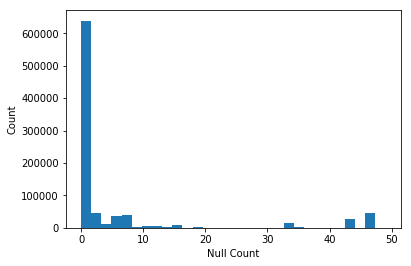

In [25]:
plt.hist(row_null_count, bins = 30)
plt.xlabel('Null Count')
plt.ylabel('Count')

In [26]:
row_null_count.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

In [27]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#subset_1 = azdias[azdias.isnull().sum(axis = 1) > np.percentile(row_null_count, 50)]
#subset_2 = azdias[azdias.isnull().sum(axis = 1) <= np.percentile(row_null_count, 50)]

subset_1 = azdias[azdias.isnull().sum(axis = 1) > outlier_condition]
subset_2 = azdias[azdias.isnull().sum(axis = 1) <= outlier_condition]

In [28]:
subset_1.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,93076.000000,93154.000000,93049.000000,93154.000000,93154.000000,93154.000000,93154.00000,93154.000000,93154.000000,93154.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.000000,6.000000,6.000000
mean,2.430863,1.527342,4.740696,3.208279,3.720495,3.128830,4.68142,4.723018,2.741246,3.729244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.166667,4.166667,3.166667
std,0.868601,0.499255,1.645017,0.646886,0.853205,0.632164,0.87635,0.741121,0.639476,0.754441,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.471960,2.562551,1.329160
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2.000000,1.000000
25%,2.000000,1.000000,4.000000,3.000000,4.000000,3.000000,5.00000,5.000000,3.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.250000,3.000000,3.000000
50%,3.000000,2.000000,6.000000,3.000000,4.000000,3.000000,5.00000,5.000000,3.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.500000,3.000000,3.000000
75%,3.000000,2.000000,6.000000,3.000000,4.000000,3.000000,5.00000,5.000000,3.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,4.500000,3.750000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.00000,5.000000,4.000000,6.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,9.000000,5.000000


In [29]:
subset_1.shape

(93154, 79)

In [30]:
subset_2.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,795264.000000,798067.000000,793318.000000,798067.000000,798067.000000,798067.000000,798067.000000,798067.000000,798067.000000,798067.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793840.000000,793941.000000,793840.000000
mean,2.795413,1.521486,3.502897,3.058916,2.716050,3.432887,2.840956,2.658361,3.114092,3.797746,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293397,3.071032
std,1.018408,0.499538,1.537613,1.377576,1.485091,1.376869,1.472781,1.399534,1.408110,2.084701,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999069,2.303376,1.360533
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,3.000000,2.000000,4.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,4.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,6.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


In [31]:
subset_2.shape

(798067, 79)

In [32]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# List of columns with no nulls
null_flag = azdias.isnull().any()
null_flag[null_flag == False]

ANREDE_KZ                False
FINANZ_MINIMALIST        False
FINANZ_SPARER            False
FINANZ_VORSORGER         False
FINANZ_ANLEGER           False
FINANZ_UNAUFFAELLIGER    False
FINANZ_HAUSBAUER         False
FINANZTYP                False
GREEN_AVANTGARDE         False
SEMIO_SOZ                False
SEMIO_FAM                False
SEMIO_REL                False
SEMIO_MAT                False
SEMIO_VERT               False
SEMIO_LUST               False
SEMIO_ERL                False
SEMIO_KULT               False
SEMIO_RAT                False
SEMIO_KRIT               False
SEMIO_DOM                False
SEMIO_KAEM               False
SEMIO_PFLICHT            False
SEMIO_TRADV              False
ZABEOTYP                 False
dtype: bool

Subset 1: 
 count    93154.000000
mean         1.527342
std          0.499255
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: ANREDE_KZ, dtype: float64 

Subset 2: 
 count    798067.000000
mean          1.521486
std           0.499538
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           2.000000
Name: ANREDE_KZ, dtype: float64


(array([ 381886.,  416181.]),
 array([ 1. ,  1.5,  2. ]),
 <a list of 2 Patch objects>)

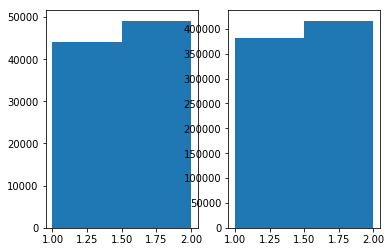

In [33]:
print('Subset 1: \n',  subset_1['ANREDE_KZ'].describe(), '\n')

print('Subset 2: \n', subset_2['ANREDE_KZ'].describe())

plt.subplot(1, 2, 1)
plt.hist(subset_1['ANREDE_KZ'], bins = 2)
plt.subplot(1, 2, 2)
plt.hist(subset_2['ANREDE_KZ'], bins = 2)

Subset 1: 
 count    93154.00000
mean         4.68142
std          0.87635
min          1.00000
25%          5.00000
50%          5.00000
75%          5.00000
max          5.00000
Name: FINANZ_ANLEGER, dtype: float64 

Subset 2: 
 count    798067.000000
mean          2.840956
std           1.472781
min           1.000000
25%           1.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: FINANZ_ANLEGER, dtype: float64


(array([ 208577.,  158227.,  137946.,  138181.,  155136.]),
 array([ 1. ,  1.8,  2.6,  3.4,  4.2,  5. ]),
 <a list of 5 Patch objects>)

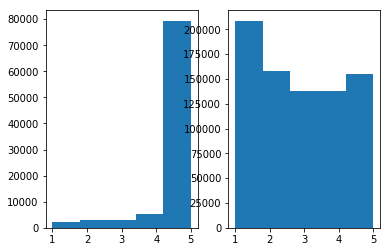

In [34]:
print('Subset 1: \n',  subset_1['FINANZ_ANLEGER'].describe(), '\n')

print('Subset 2: \n', subset_2['FINANZ_ANLEGER'].describe())

plt.subplot(1, 2, 1)
plt.hist(subset_1['FINANZ_ANLEGER'], bins = 5)
plt.subplot(1, 2, 2)
plt.hist(subset_2['FINANZ_ANLEGER'], bins = 5)

Subset 1: 
 count    93154.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: GREEN_AVANTGARDE, dtype: float64 

Subset 2: 
 count    798067.000000
mean          0.219562
std           0.413950
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: GREEN_AVANTGARDE, dtype: float64


(array([ 622842.,  175225.]),
 array([ 0. ,  0.5,  1. ]),
 <a list of 2 Patch objects>)

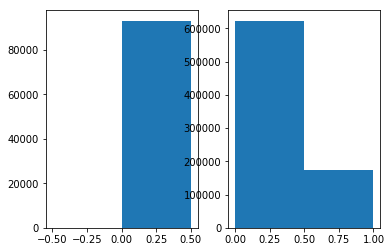

In [35]:
print('Subset 1: \n',  subset_1['GREEN_AVANTGARDE'].describe(), '\n')

print('Subset 2: \n', subset_2['GREEN_AVANTGARDE'].describe())

plt.subplot(1, 2, 1)
plt.hist(subset_1['GREEN_AVANTGARDE'], bins = 2)
plt.subplot(1, 2, 2)
plt.hist(subset_2['GREEN_AVANTGARDE'], bins = 2)

Subset 1: 
 count    93154.000000
mean         5.636119
std          1.290843
min          1.000000
25%          6.000000
50%          6.000000
75%          6.000000
max          7.000000
Name: SEMIO_FAM, dtype: float64 

Subset 2: 
 count    798067.000000
mean          4.113588
std           1.913707
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max           7.000000
Name: SEMIO_FAM, dtype: float64


(array([  75730.,  139562.,   94815.,  133930.,  131841.,  106628.,  115561.]),
 array([ 1.        ,  1.85714286,  2.71428571,  3.57142857,  4.42857143,
         5.28571429,  6.14285714,  7.        ]),
 <a list of 7 Patch objects>)

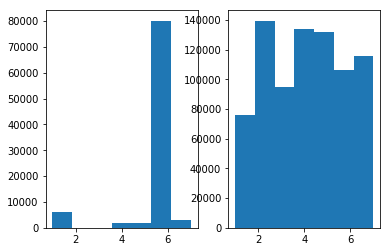

In [36]:
print('Subset 1: \n',  subset_1['SEMIO_FAM'].describe(), '\n')

print('Subset 2: \n', subset_2['SEMIO_FAM'].describe())

plt.subplot(1, 2, 1)
plt.hist(subset_1['SEMIO_FAM'], bins = 7)
plt.subplot(1, 2, 2)
plt.hist(subset_2['SEMIO_FAM'], bins = 7)

Subset 1: 
 count    93154.000000
mean         3.224113
std          0.711373
min          1.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          6.000000
Name: ZABEOTYP, dtype: float64 

Subset 2: 
 count    798067.000000
mean          3.378584
std           1.407775
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           6.000000
Name: ZABEOTYP, dtype: float64


(array([ 123458.,   33005.,  282243.,  207532.,   80963.,   70866.]),
 array([ 1.        ,  1.83333333,  2.66666667,  3.5       ,  4.33333333,
         5.16666667,  6.        ]),
 <a list of 6 Patch objects>)

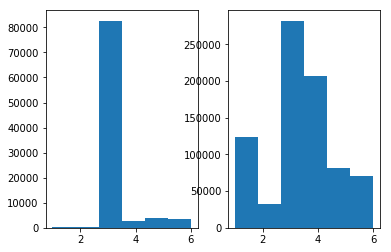

In [37]:
print('Subset 1: \n',  subset_1['ZABEOTYP'].describe(), '\n')

print('Subset 2: \n', subset_2['ZABEOTYP'].describe())

plt.subplot(1, 2, 1)
plt.hist(subset_1['ZABEOTYP'], bins = 6)
plt.subplot(1, 2, 2)
plt.hist(subset_2['ZABEOTYP'], bins = 6)

#### Discussion 1.1.3: Assess Missing Data in Each Row

For many variables such as FINANZ_ANLEGER (financial topology), SEMIO_FAM (personality topology), ZABEOTYP (energy consumption), and GREEN_AVANTGARDE (environmental sustainability membership) the data that have few/no missing values are qualitatively different than those with lots of missing values. From the histograms and summary statistics, we can see that the values for these variables vary between the two subsets.

However, as you can see from the above graphs and summary statistics, the distribution of the variable ANREDE_KZ (gender) does not vary much between the two subsets. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [38]:
# How many features are there of each data type?

feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [39]:
# Find attributes that are categorical
categorical_variable_name = feat_info['attribute'][feat_info['type'] == 'categorical']
categorical_variable_name

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [40]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Number of levels in each categorical column
categorical_columns = azdias[azdias.columns.intersection(categorical_variable_name)]
categorical_columns.nunique().sort_values(ascending=True)

ANREDE_KZ            2
OST_WEST_KZ          2
VERS_TYP             2
SOHO_KZ              2
GREEN_AVANTGARDE     2
NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_STATUS_GROB       5
LP_FAMILIE_GROB      5
FINANZTYP            6
ZABEOTYP             6
CJT_GESAMTTYP        6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEU_2015      44
dtype: int64

In [41]:
# Re-encode categorical variable(s) to be kept in the analysis.
categorical_columns.loc[:,categorical_columns.nunique()==2].head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
0,1,0,NaN,NaN,NaN
1,2,0,1.0,2.0,W
2,2,1,0.0,1.0,W
3,2,0,0.0,1.0,W
4,1,0,0.0,2.0,W


In [42]:
azdias['OST_WEST_KZ'].value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

In [43]:
# re-encode OST_WEST_KZ column with 0,1 instead of W, O
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].replace('W', 0).replace('O', 1)
azdias['OST_WEST_KZ'].value_counts()

0.0    629528
1.0    168545
Name: OST_WEST_KZ, dtype: int64

In [44]:
# Remove multi-level variables from the dataset
multi_level_columns = categorical_columns.loc[:,categorical_columns.nunique()>2].columns

azdias = azdias.drop(columns = multi_level_columns)

In [45]:
azdias.shape

(891221, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features


I kept all binary variables (ANREDE_KZ, OST_WEST_KZ, VERS_TYP, SOHO_KZ, GREEN_AVANTGARDE). I re-encoded the binary variable OST_WEST_KZ to created a dummy variable. I deleted all multi-level categorical variables. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [46]:
# View mixed variables
feat_info[feat_info['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


In [47]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [48]:
# Engineer two new variables

# Create Decade varaible
decade_replace_values = {1:1, 2:1,
                        3:2, 4:2,
                        5:3, 6:3, 7:3,
                        8:4, 9:4,
                        10:5, 11:5, 12:5, 13:5,
                        14:6, 15:6}
azdias['Decade'] = azdias['PRAEGENDE_JUGENDJAHRE']
azdias['Decade'] = azdias['Decade'].replace(decade_replace_values)

azdias['Decade'].value_counts()

6.0    231244
4.0    179558
5.0    151770
3.0    116078
2.0     75646
1.0     28761
Name: Decade, dtype: int64

In [49]:
# Create Movement Variable

movement_replace_values = {1:0, 2:1,
                        3:0, 4:1,
                        5:1, 6:1, 7:1,
                        8:0, 9:1,
                        10:1, 11:0, 12:1, 13:0,
                        14:1, 15:0}
azdias['Movement'] = azdias['PRAEGENDE_JUGENDJAHRE']
azdias['Movement'] = azdias['Movement'].replace(movement_replace_values)

azdias['Movement'].value_counts()

1.0    476529
0.0    306528
Name: Movement, dtype: int64

In [50]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias['CAMEO_INTL_2015'].value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [51]:
# Engineer two new variables

# Create Wealth variable
wealth_replace_values = {'11':1, '12':1, '13':1, '14':1, '15':1,
                        '21':2, '22':2, '23':2, '24':2, '25':2,
                        '31':3, '32':3, '33':3, '34':3, '35':3,
                        '41':4, '42':4, '43':4, '44':4, '45':4,
                        '51':5, '52':5, '53':5, '54':5, '55':5}
azdias['Wealth'] = azdias['CAMEO_INTL_2015']
azdias['Wealth'] = azdias['Wealth'].replace( wealth_replace_values)


In [52]:
azdias['Wealth'].value_counts()

5.0    223582
2.0    190691
4.0    189960
1.0    119443
3.0     68193
Name: Wealth, dtype: int64

In [53]:
# Create Life_Stage variable

life_stage_replace_values = {'11':1, '21':1, '31':1, '41':1, '51':1,
                        '12':2, '22':2, '32':2, '42':2, '52':2,
                        '13':3, '23':3, '33':3, '43':3, '53':3,
                        '14':4, '24':4, '34':4, '44':4, '54':4,
                        '15':5, '25':5, '35':5, '45':5, '55':5}
azdias['Life_Stage'] = azdias['CAMEO_INTL_2015']
azdias['Life_Stage'] = azdias['Life_Stage'].replace(life_stage_replace_values)

In [54]:
azdias['Life_Stage'].value_counts()

1.0    245054
4.0    232777
3.0    119693
5.0    117045
2.0     77300
Name: Life_Stage, dtype: int64

In [55]:
# drop remaining mixed variables
azdias = azdias.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
                      'WOHNLAGE', 'PLZ8_BAUMAX'], axis = 1)


#### Discussion 1.2.2: Engineer Mixed-Type Features

There were 7 mixed variables in this data. Of the seven variables I dropped 5 (KBA05_BAUMAX had been dropped in previous step) and re-engineered 2. I created four new variables from these engineered variables. From the PRAEGENDE_JUGENDJAHRE variable, I created movement and decade variables based on the values in the original column. From the CAMEO_INTL_2015, I created life stage and wealth variables. I then dropped the original PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 columns.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [56]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


# drop original columns from dataset
azdias = azdias.drop('PRAEGENDE_JUGENDJAHRE', 1)
azdias = azdias.drop('CAMEO_INTL_2015', 1)

azdias.shape

(891221, 64)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [57]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
        
    for i in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[i]['missing_or_unknown'] 
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') 
                          else value for value in missing_or_unknown] 
        if missing_or_unknown != ['']:
            df = df.replace({feat_info.iloc[i]['attribute']: missing_or_unknown}, np.nan)
    
    # remove selected columns and rows, ...
    # remove outlier columns
    percent_null = azdias.isnull().sum()/len(azdias) * 100
    outlier_condition = percent_null.mean() + 1.5* (np.percentile(percent_null, 75) - np.percentile(percent_null, 25))
    df = df.drop(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], axis = 1)

    # remove rows that are above cut-off
    df = df[df.isnull().sum(axis = 1) <= outlier_condition]
    
    # select, re-encode, and engineer column values.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace('W', 0).replace('O', 1)

    categorical_variable_name = feat_info['attribute'][feat_info['type'] == 'categorical']
    categorical_columns = df[df.columns.intersection(categorical_variable_name)]
    multi_level_columns = categorical_columns.loc[:,categorical_columns.nunique()>2].columns
    df = df.drop(columns = multi_level_columns)


    decade_replace_values = {1:1, 2:1,
                            3:2, 4:2,
                            5:3, 6:3, 7:3,
                            8:4, 9:4,
                            10:5, 11:5, 12:5, 13:5,
                            14:6, 15:6}
    df['Decade'] = df['PRAEGENDE_JUGENDJAHRE']
    df['Decade'] = df['Decade'].replace(decade_replace_values)

    movement_replace_values = {1:0, 2:1,
                            3:0, 4:1,
                            5:1, 6:1, 7:1,
                            8:0, 9:1,
                            10:1, 11:0, 12:1, 13:0,
                            14:1, 15:0}
    df['Movement'] = df['PRAEGENDE_JUGENDJAHRE']
    df['Movement'] = df['Movement'].replace(movement_replace_values)

    wealth_replace_values = {11:1, 12:1, 13:1, 14:1, 15:1,
                            21:2, 22:2, 23:2, 24:2, 25:2,
                            31:3, 32:3, 33:3, 34:3, 35:3,
                            41:4, 42:4, 43:4, 44:4, 45:4,
                            51:5, 52:5, 53:5, 54:5, 55:5}
    df['Wealth'] = df['CAMEO_INTL_2015']
    df['Wealth'] = df.replace({'Wealth': wealth_replace_values})

    life_stage_replace_values = {11:1, 21:1, 31:1, 41:1, 51:1,
                            12:2, 22:2, 32:2, 42:2, 52:2,
                            13:3, 23:3, 33:3, 43:3, 53:3,
                            14:4, 24:4, 34:4, 44:4, 54:4,
                            15:5, 25:5, 35:5, 45:5, 55:5}
    df['Life_Stage'] = df['CAMEO_INTL_2015']
    df['Life_Stage'] = df.replace({'Life_Stage': life_stage_replace_values})

    df = df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
                          'WOHNLAGE', 'PLZ8_BAUMAX'], axis = 1)
    df = df.drop('PRAEGENDE_JUGENDJAHRE', 1)
    df = df.drop('CAMEO_INTL_2015', 1)
    
    # Return the cleaned dataframe.
    return df
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [58]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# remove all observations with missing values
azdias = azdias.dropna(axis =0)


In [59]:
azdias.shape

(623211, 64)

In [60]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias)


### Discussion 2.1: Apply Feature Scaling

For feature scaling, I decided to use Standard Scaler which scales each feature to have a mean of 0 and standard deviation of 1.

To handle missing values, I decided to remove all missing values from the dataset. As imputation can lead to bias depending on the method used to compute and can be time and resource consuming, I decided to go with the simpler approach of removing all missing values. When the missing values are removed, there are still 623,211 observations, which is plenty to fit our model. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [61]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_scaled)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

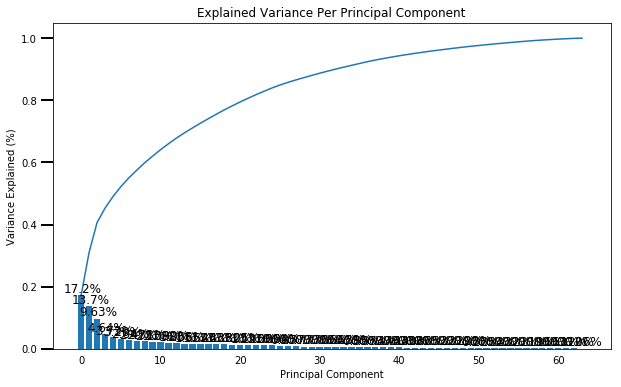

In [62]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

In [63]:
# variance explained by all components
pca.explained_variance_ratio_.sum()


0.99999999999999989

In [64]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_updated = PCA(n_components = 45)
azdias_pca = pca_updated.fit_transform(azdias_scaled)


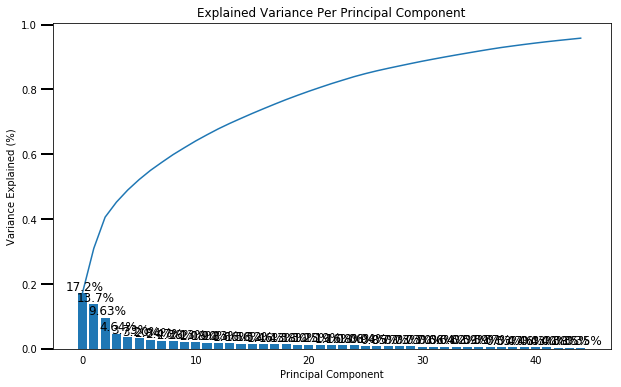

In [65]:
scree_plot(pca_updated)

In [66]:
# Variance explained by 45 components
pca_updated.explained_variance_ratio_.sum()

0.9583377628441575

### Discussion 2.2: Perform Dimensionality Reduction


I am retaining 45 components as this explains over 95% of the variance in the data while also reducing the number of components by about 25.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [67]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weight_mapping(pca, component):
    mapping = pd.DataFrame(pca.components_, columns = azdias.columns)
    weights = mapping.iloc[component]
    weights = weights.sort_values(ascending = False)
    return weights

pca_weight_mapping(pca_updated, component = 0)

PLZ8_ANTG3               0.213884
PLZ8_ANTG4               0.207601
Wealth                   0.194261
HH_EINKOMMEN_SCORE       0.189274
ORTSGR_KLS9              0.186834
EWDICHTE                 0.183754
FINANZ_SPARER            0.171294
KBA05_ANTG4              0.145028
PLZ8_ANTG2               0.142084
FINANZ_HAUSBAUER         0.141514
SEMIO_PFLICHT            0.139928
SEMIO_REL                0.138234
ARBEIT                   0.137413
Decade                   0.133178
KBA05_ANTG3              0.129820
ANZ_HAUSHALTE_AKTIV      0.128859
SEMIO_TRADV              0.126496
RELAT_AB                 0.125592
SEMIO_RAT                0.114229
SEMIO_MAT                0.102074
FINANZ_UNAUFFAELLIGER    0.101382
SEMIO_FAM                0.099698
SEMIO_KULT               0.098416
FINANZ_ANLEGER           0.089603
REGIOTYP                 0.068933
OST_WEST_KZ              0.058553
SEMIO_SOZ                0.056509
Movement                 0.043953
KKK                      0.041740
HEALTH_TYP    

In [68]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_mapping(pca_updated, component = 1)

ALTERSKATEGORIE_GROB     0.240459
SEMIO_ERL                0.219065
FINANZ_VORSORGER         0.209996
SEMIO_LUST               0.165686
RETOURTYP_BK_S           0.160900
FINANZ_HAUSBAUER         0.132901
PLZ8_ANTG3               0.124918
W_KEIT_KIND_HH           0.120028
PLZ8_ANTG4               0.119726
SEMIO_KRIT               0.119418
EWDICHTE                 0.117916
ORTSGR_KLS9              0.117769
SEMIO_KAEM               0.113551
Wealth                   0.097757
ARBEIT                   0.087602
KBA05_ANTG4              0.087120
ANREDE_KZ                0.086843
PLZ8_ANTG2               0.082963
RELAT_AB                 0.082257
ANZ_HAUSHALTE_AKTIV      0.077223
HH_EINKOMMEN_SCORE       0.071942
SEMIO_DOM                0.069123
KBA05_ANTG3              0.065497
WOHNDAUER_2008           0.050861
OST_WEST_KZ              0.038235
FINANZ_MINIMALIST        0.036069
ANZ_HH_TITEL             0.034188
REGIOTYP                 0.031820
VERS_TYP                 0.030982
PLZ8_HHZ      

In [69]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_mapping(pca_updated, component = 2)

SEMIO_VERT               0.349355
SEMIO_SOZ                0.264372
SEMIO_FAM                0.253300
SEMIO_KULT               0.234159
FINANZ_MINIMALIST        0.157115
RETOURTYP_BK_S           0.114828
FINANZ_VORSORGER         0.097250
W_KEIT_KIND_HH           0.093712
ALTERSKATEGORIE_GROB     0.081043
SEMIO_REL                0.078584
SEMIO_LUST               0.071462
SEMIO_MAT                0.049372
GREEN_AVANTGARDE         0.041906
PLZ8_ANTG4               0.041699
EWDICHTE                 0.041547
ORTSGR_KLS9              0.041295
PLZ8_ANTG3               0.040811
WOHNDAUER_2008           0.034712
ARBEIT                   0.029441
RELAT_AB                 0.027505
KBA05_ANTG4              0.027396
PLZ8_ANTG2               0.026603
ANZ_HAUSHALTE_AKTIV      0.025281
Wealth                   0.024349
VERS_TYP                 0.020498
ANZ_HH_TITEL             0.013175
OST_WEST_KZ              0.012667
ANZ_TITEL                0.009246
KBA05_ANTG3              0.006528
PLZ8_HHZ      

### Discussion 2.3: Interpret Principal Components

First component: FINANZ_SPARER(financial sparer) has a positive value showing the component is positively associated with this variable while FINANZ_MINIMALIST (financial minimalist) has a negative value showing a negative association. With high positive weights in variables such as FINANZ_SPARER and Wealth, this component increases with these features and these features (Money saver and wealth) vary together. The PLZ8_ANTG3 and PLZ8_ANTG4 have the highest weights showing that this component looks strongly at number of households in communities.

Second component: ALTERSKATEGORIE_GROB (age) has a positive value showing the component is positively associated with this variable while SEMIO_REL (religios personality typology) has a negative value showing a negative association. With high positive weights in variables such as ALTERSKATEGORIE_GROB (age) and personality and financial typology variables, this component focuses on variables like age, finances, and personality.

Third component: SEMIO_VERT (dreamful personality typology) has a positive value showing the component is positively associated with this variable while ANREDE_KZ (gender) has a negative value showing a negative association. This component focuses heavily on personality typology as most of the SEMIO variables have relatively high positive and relatively low negative weights. The component is associated positvely with personalities like dreamful, social, cultural and family minded while it varies negatively with personalities like combatative, dominant, and critical minded. The ANREDE_KZ (gender) has a very low negative weight showing that this component decreases as gender increases (goes from male to female).  

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [101]:
# Over a number of different cluster counts...

scores = []
#for center in list(range(1, 25, 2)):
for center in list(range(1, 15)):
    kmeans= KMeans(center)
    model = kmeans.fit(azdias_scaled)
    scores.append(abs(model.score(azdias_scaled)))

    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
# Note: originally ran from range 1-25 and found optimal k. 
# When re-running I ran from 1-15 in order to reduce computation time 

Text(0,0.5,'Average Distance From Centroid')

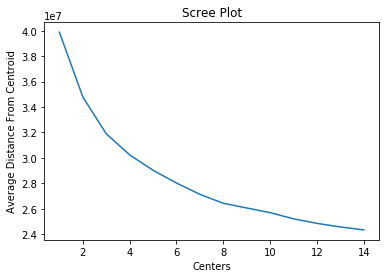

In [102]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
#centers = list(range(1,25,2))

centers = list(range(1,15))
plt.plot(centers, scores)
plt.title("Scree Plot")
plt.xlabel('Centers')
plt.ylabel('Average Distance From Centroid') 


In [70]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_ = KMeans(7)
kmeans_model = kmeans_.fit_predict(azdias_pca)


### Discussion 3.1: Apply Clustering to General Population

I decided to cluster the population in 7 segments. This is where the elbow of the curve is located, showing it is the optimal choice for the number of clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [71]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [72]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(customers)


In [73]:
customers_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115643 entries, 0 to 191651
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB     115643 non-null float64
ANREDE_KZ                115643 non-null int64
FINANZ_MINIMALIST        115643 non-null int64
FINANZ_SPARER            115643 non-null int64
FINANZ_VORSORGER         115643 non-null int64
FINANZ_ANLEGER           115643 non-null int64
FINANZ_UNAUFFAELLIGER    115643 non-null int64
FINANZ_HAUSBAUER         115643 non-null int64
GREEN_AVANTGARDE         115643 non-null int64
HEALTH_TYP               115643 non-null float64
RETOURTYP_BK_S           115643 non-null float64
SEMIO_SOZ                115643 non-null int64
SEMIO_FAM                115643 non-null int64
SEMIO_REL                115643 non-null int64
SEMIO_MAT                115643 non-null int64
SEMIO_VERT               115643 non-null int64
SEMIO_LUST               115643 non-null int64
SEMIO_ERL                115643 non-null int64
SEMIO_KULT               115643 non-n

In [121]:
# drop NA
customers_cleaned = customers_cleaned.dropna(axis =0)


In [74]:
#Scale and PCA
customers_scaled = scaler.transform(customers_cleaned)


customers_pca = pca_updated.transform(customers_scaled)


In [75]:
# Cluster predictions

customers_predictions = kmeans_.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [76]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

Clusters = pd.Series(kmeans_model)
Cluster_counts = Clusters.value_counts()
Cluster_proportions = Cluster_counts/len(Clusters) * 100
Cluster_proportions

1    17.767337
5    17.563073
2    14.247502
4    14.148017
6    13.135840
3    12.122540
0    11.015691
dtype: float64

In [77]:
Clusters_customers = pd.Series(customers_predictions)
Cluster_counts_customers = Clusters_customers.value_counts()
Cluster_proportions_customers = Cluster_counts_customers/len(Clusters_customers) * 100
Cluster_proportions_customers

1    52.187335
5    19.656183
4    12.889669
2    10.447671
6     2.529336
0     1.208893
3     1.080913
dtype: float64

[Text(0.5,1,'Population Data')]

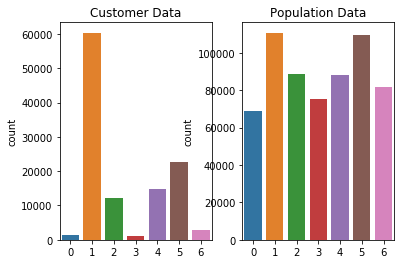

In [78]:
plt.subplot(1, 2, 1)
sns.countplot(customers_predictions).set(title='Customer Data')
plt.subplot(1, 2, 2)
sns.countplot(kmeans_model).set(title='Population Data')

In [81]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# cluster 1

In [82]:
Centers_1 = scaler.inverse_transform(pca_updated.inverse_transform(kmeans_.cluster_centers_[1]))

In [83]:
# Map the center's weights back to column names to be able to interpret weights
Centers_1 = pd.Series(Centers_1, index = customers_cleaned.columns).sort_values(ascending = False)
Centers_1

MIN_GEBAEUDEJAHR         1992.698293
KBA13_ANZAHL_PKW          682.728282
WOHNDAUER_2008              8.429067
SEMIO_VERT                  6.033147
INNENSTADT                  5.376151
SEMIO_LUST                  5.191819
SEMIO_KULT                  5.004087
SEMIO_SOZ                   4.855190
BALLRAUM                    4.793630
SEMIO_FAM                   4.674785
FINANZ_MINIMALIST           4.648566
FINANZ_VORSORGER            4.266150
W_KEIT_KIND_HH              4.244503
SEMIO_ERL                   4.202133
ORTSGR_KLS9                 4.199084
MOBI_REGIO                  4.107698
KBA05_GBZ                   4.090276
REGIOTYP                    4.018700
GEBAEUDETYP_RASTER          4.013293
PLZ8_GBZ                    3.889772
RETOURTYP_BK_S              3.866635
SEMIO_REL                   3.762424
KONSUMNAEHE                 3.688087
Decade                      3.567427
PLZ8_HHZ                    3.498113
Life_Stage                  3.445609
SEMIO_DOM                   3.418362
H

In [84]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#cluster 1
Centers_3 = scaler.inverse_transform(pca_updated.inverse_transform(kmeans_.cluster_centers_[3]))

In [85]:
Centers_3 = pd.Series(Centers_3, index = customers_cleaned.columns).sort_values(ascending = False)
Centers_3.head

<bound method NDFrame.head of MIN_GEBAEUDEJAHR         1992.356557
KBA13_ANZAHL_PKW          546.719417
ANZ_HAUSHALTE_AKTIV        13.106669
WOHNDAUER_2008              7.253232
ORTSGR_KLS9                 6.686225
SEMIO_RAT                   6.528702
SEMIO_DOM                   6.483821
SEMIO_KAEM                  6.219318
SEMIO_TRADV                 6.180968
SEMIO_PFLICHT               6.159804
Decade                      5.664461
SEMIO_KRIT                  5.530148
HH_EINKOMMEN_SCORE          5.495725
SEMIO_REL                   5.374980
EWDICHTE                    4.960662
SEMIO_MAT                   4.885846
REGIOTYP                    4.823565
SEMIO_KULT                  4.268292
Wealth                      4.208910
FINANZ_SPARER               4.180577
SEMIO_ERL                   4.151798
FINANZ_HAUSBAUER            4.105821
FINANZ_ANLEGER              4.050446
SEMIO_FAM                   3.960236
W_KEIT_KIND_HH              3.893834
PLZ8_HHZ                    3.756538
FINANZ_U

### Discussion 3.3: Compare Customer Data to Demographics Data

Cluster 1 is overrepresented in the customer data, while cluster 3 is underrepresented in the customer data. In the population data, Cluster 1 makes up 17.77% of the data and makes up 52.19% of the data in the customer data, showing this cluster is popualr with the company. In the population data, Cluster 3 makes up 12.12% of the data while only making up 1.08% of the customer data showing it is unpopular with the company. 

Cluster 1 is made up of....  
- Life stage (3.45): Families with school age children
- Wealth (2.33): Prosperous Households
- RETOURTYP_BK_S (3.87): conservative Low-Returner
- SEMIO_VERT (6.03), SEMIO_LUST (5.19), SEMIO_KULT (5.00), SEMIO_SOZ (4.86), SEMIO_FAM (4.67): dreamful, sensual oriented, cultural minded, socially minded, and family minded
- BALLRAUM (4.79): about 40-50km from closest urban center
- FINANZ_MINIMALIST (4.65) and FINANZ_VORSORGER (4.27): low financial interest and prepared financially

Cluster 3 is made up of....
- Life stage (2.24): Young Couples With Children
- Wealth (4.21): Less Affluent Households
- ANREDE_KZ (2.02): Majority females
- RETOURTYP_BK_S (4.54): conservative Low-Returner/determined Minimal-Returner
- SEMIO_RAT (6.53), SEMIO_DOM (6.48), SEMIO_KAEM (6.22), SEMIO_TRADV (6.18), SEMIO_PFLICHT (6.16) : rational, dominant, combatative, traditional, dutiful
- ALTERSKATEGORIE_GROB (1.56): > 60 years old
- FINANZ_SPARER (4.18): money saver

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.